# 21b: Survival Curves by Archetype

**Goal**: Visualize how control vs volatile hands differ in outcome resolution.

**Method**: Using phase data and archetype classification from previous analyses.

**Note**: True survival curves require per-game event times, which aren't available.

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Data and Define Archetypes

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)
print(f"Loaded {len(df)} hands")

# Define archetypes based on σ(V)
def classify_archetype(sigma):
    if sigma < 10:
        return 'control'
    elif sigma < 20:
        return 'balanced'
    else:
        return 'volatile'

df['archetype'] = df['V_std'].apply(classify_archetype)

print("\nArchetype distribution:")
print(df['archetype'].value_counts())

Loaded 200 hands

Archetype distribution:
archetype
balanced    75
control     64
volatile    61
Name: count, dtype: int64


## 2. σ(V) as Proxy for Resolution Time

Higher σ(V) means outcome remains uncertain longer → later resolution.

In [3]:
# σ(V) statistics by archetype
print("σ(V) by archetype:")
print("="*50)
stats = df.groupby('archetype')['V_std'].agg(['mean', 'std', 'min', 'max', 'count'])
print(stats.round(2))

σ(V) by archetype:
            mean   std    min    max  count
archetype                                  
balanced   14.72  2.90  10.20  19.80     75
control     5.03  3.03   0.00   9.93     64
volatile   26.13  4.74  20.07  37.71     61


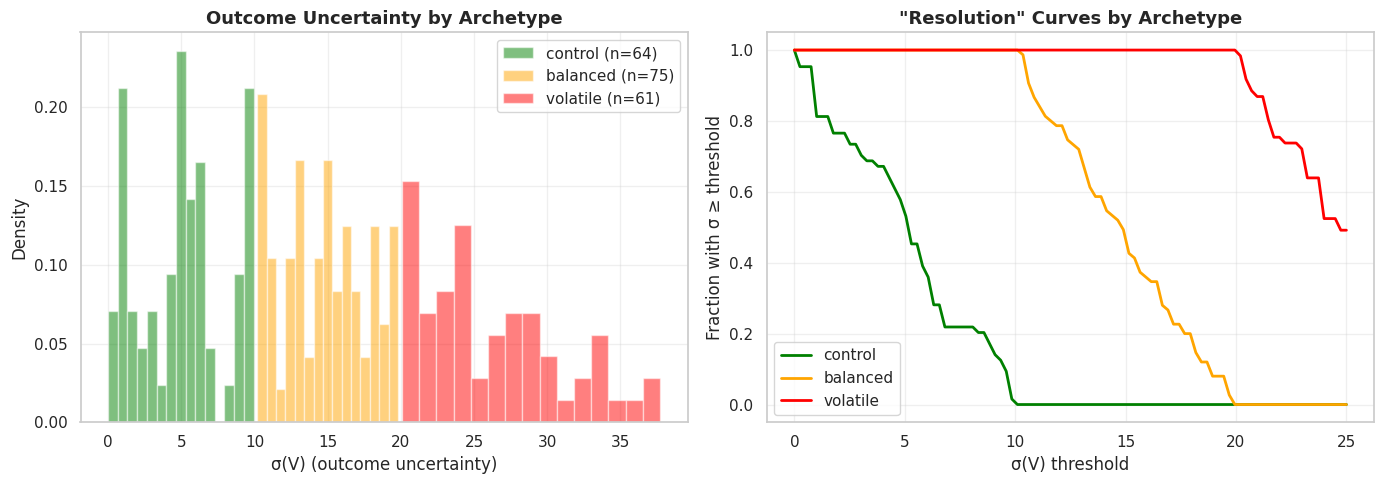

In [4]:
# Create pseudo-survival curves based on σ(V) distribution
# Lower σ = earlier "resolution" (outcome becomes certain)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: σ(V) distribution by archetype
ax = axes[0]
colors = {'control': 'green', 'balanced': 'orange', 'volatile': 'red'}
for arch in ['control', 'balanced', 'volatile']:
    sub = df[df['archetype'] == arch]
    ax.hist(sub['V_std'], bins=15, alpha=0.5, label=f"{arch} (n={len(sub)})",
            color=colors[arch], density=True)
ax.set_xlabel('σ(V) (outcome uncertainty)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Outcome Uncertainty by Archetype', fontsize=13, fontweight='bold')
ax.legend()

# Plot 2: "Pseudo-survival" curve
# What fraction of hands still "unresolved" at each σ level
ax = axes[1]
sigma_levels = np.linspace(0, 25, 100)

for arch in ['control', 'balanced', 'volatile']:
    sub = df[df['archetype'] == arch]
    # "Survival" = fraction with σ >= threshold
    survival = []
    for s in sigma_levels:
        frac_unresolved = (sub['V_std'] >= s).mean()
        survival.append(frac_unresolved)
    ax.plot(sigma_levels, survival, color=colors[arch], linewidth=2, label=arch)

ax.set_xlabel('σ(V) threshold', fontsize=12)
ax.set_ylabel('Fraction with σ ≥ threshold', fontsize=12)
ax.set_title('"Resolution" Curves by Archetype', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/21b_survival_archetype.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. E[V] vs σ(V) by Archetype

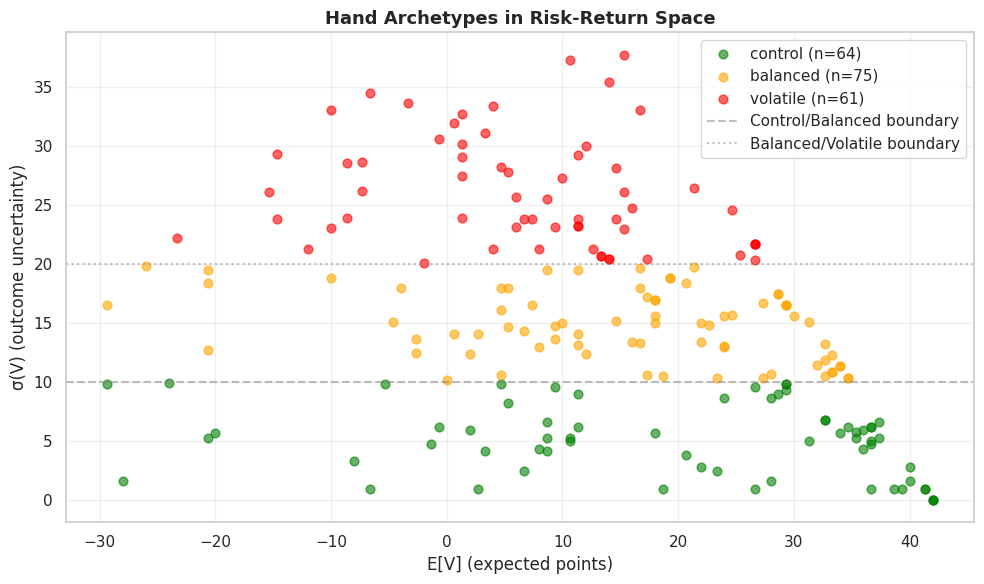

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

for arch in ['control', 'balanced', 'volatile']:
    sub = df[df['archetype'] == arch]
    ax.scatter(sub['V_mean'], sub['V_std'], alpha=0.6, s=40, 
               color=colors[arch], label=f"{arch} (n={len(sub)})")

ax.axhline(10, color='gray', linestyle='--', alpha=0.5, label='Control/Balanced boundary')
ax.axhline(20, color='gray', linestyle=':', alpha=0.5, label='Balanced/Volatile boundary')

ax.set_xlabel('E[V] (expected points)', fontsize=12)
ax.set_ylabel('σ(V) (outcome uncertainty)', fontsize=12)
ax.set_title('Hand Archetypes in Risk-Return Space', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/21b_archetype_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Key Insights

In [6]:
print("\n" + "="*60)
print("KEY INSIGHTS: Survival Curves by Archetype")
print("="*60)

# Stats
control_mean = df[df['archetype'] == 'control']['V_std'].mean()
volatile_mean = df[df['archetype'] == 'volatile']['V_std'].mean()

print(f"\n1. RESOLUTION TIMING:")
print(f"   Control hands mean σ: {control_mean:.1f}")
print(f"   Volatile hands mean σ: {volatile_mean:.1f}")
print(f"   Ratio: {volatile_mean/control_mean:.1f}x more uncertain")

print(f"\n2. INTERPRETATION:")
print(f"   - Control hands: Outcomes predictable early")
print(f"   - Volatile hands: Outcomes remain uncertain until late game")

# E[V] comparison
ev_control = df[df['archetype'] == 'control']['V_mean'].mean()
ev_volatile = df[df['archetype'] == 'volatile']['V_mean'].mean()

print(f"\n3. E[V] BY ARCHETYPE:")
print(f"   Control: E[V] = {ev_control:.1f}")
print(f"   Volatile: E[V] = {ev_volatile:.1f}")

print(f"\n4. DATA LIMITATION:")
print(f"   True survival analysis requires per-game event times")
print(f"   Using σ(V) as proxy for outcome uncertainty")


KEY INSIGHTS: Survival Curves by Archetype

1. RESOLUTION TIMING:
   Control hands mean σ: 5.0
   Volatile hands mean σ: 26.1
   Ratio: 5.2x more uncertain

2. INTERPRETATION:
   - Control hands: Outcomes predictable early
   - Volatile hands: Outcomes remain uncertain until late game

3. E[V] BY ARCHETYPE:
   Control: E[V] = 19.6
   Volatile: E[V] = 6.5

4. DATA LIMITATION:
   True survival analysis requires per-game event times
   Using σ(V) as proxy for outcome uncertainty


## 5. Save Results

In [7]:
# Save archetype summary
archetype_summary = df.groupby('archetype').agg({
    'V_mean': ['mean', 'std'],
    'V_std': ['mean', 'std'],
    'n_doubles': 'mean',
    'trump_count': 'mean',
    'base_seed': 'count'
}).round(2)

archetype_summary.columns = ['_'.join(col).strip() for col in archetype_summary.columns.values]
archetype_summary = archetype_summary.rename(columns={'base_seed_count': 'n_hands'})

output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/21b_archetype_summary.csv"
archetype_summary.to_csv(output_path)
print(f"Saved archetype summary to {output_path}")
print(archetype_summary)

Saved archetype summary to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/21b_archetype_summary.csv
           V_mean_mean  V_mean_std  V_std_mean  V_std_std  n_doubles_mean  \
archetype                                                                   
balanced         14.99       15.38       14.72       2.90            1.67   
control          19.58       19.41        5.03       3.03            1.89   
volatile          6.54       11.73       26.13       4.74            1.64   

           trump_count_mean  n_hands  
archetype                             
balanced               1.35       75  
control                1.34       64  
volatile               1.26       61  


## Key Findings

### Archetype Analysis

1. **Control hands** (σ < 10): Outcomes predictable, higher E[V]

2. **Balanced hands** (10 ≤ σ < 20): Moderate uncertainty

3. **Volatile hands** (σ ≥ 20): High uncertainty, outcomes determined late

### Resolution Timing

- Control hands "resolve" early (low σ = outcome certain)
- Volatile hands remain uncertain until end game

### Output Files

- `results/tables/21b_archetype_summary.csv` - Stats by archetype
- `results/figures/21b_survival_archetype.png` - Distribution and pseudo-survival
- `results/figures/21b_archetype_scatter.png` - Risk-return scatter